## PICKS

**link to the data:**
https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm

In [24]:
#!conda install pyspark
id_values = '1'

In [25]:
# Load our own functions
%load_ext autoreload
%autoreload 2
from utils.plots import *
from utils.outlier import *
from utils.partitions import *
from utils.complete_missing_dates import *
from utils.df_transformations import *

# import necesary libraries
import os
import sys

#pyspark libraries
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp, from_unixtime
from pyspark.sql.functions import col , column, lit
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year, month, dayofmonth
import pyspark.sql.functions as sf

#plot libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#other
import datetime
import pandas as pd
import numpy as np

# Configuration properties of Apache Spark
APP_NAME = 'pyspark_python'
MASTER = 'local[*]'

conf = SparkConf().setAppName(APP_NAME)
conf = conf.setMaster(MASTER)
spark = SparkSession.builder.config(conf = conf).getOrCreate()
sc = spark.sparkContext

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# load data
modelDataFile = "data/data_bank/trans.asc"

df_input = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'true')\
  .option('inferSchema', 'true')\
  .option("delimiter", ";") \
  .load(modelDataFile)

In [27]:
# Date transformation
df_input_date = (df_input.withColumn("orig_date", col("date").cast("string"))
                .withColumn("date", to_date(from_unixtime(unix_timestamp('orig_date', 'yyMMdd'))))
 .withColumn("date", to_date(from_unixtime(unix_timestamp('date', 'yyMMdd')))))

# Type of transaction: "PRIJEM" stands for credit and "VYDAJ" stands for withdrawal
df_trans = df_input_date.withColumn("is_expense", sf.when((col('type') == 'VYDAJ'), 1).otherwise(0))

# Select columns of interest
cols = ['trans_id', 'date','account_id','balance', 'amount','is_expense']
df_trans = df_trans.select(*cols)

#Montly partition (end of the month): because we aggregate the transactions of the month
df_trans = df_trans.withColumn('monthly_partition', create_partitions_from_df('date', "yyyy-MM-dd"))

#Sort by transaction id and date 
df_trans = df_trans.orderBy(["account_id", "date", "trans_id"], ascending = True)

## Group by Expenses & income
df_inc_exp = (df_trans.withColumn('income', sf.when(col('is_expense') == 0, col('amount')).otherwise(0))
             .withColumn('expense', sf.when(col('is_expense') == 1, col('amount')).otherwise(0)))
df_group = (df_inc_exp.groupBy("account_id", "monthly_partition")
                  .agg(sf.sum('income'), sf.sum('expense'), sf.count(sf.lit('monthly_partition')), sf.sum('is_expense'))
                  .withColumnRenamed('sum(income)', 'montly_income')
                 .withColumnRenamed('sum(expense)', 'montly_expense')
                 .withColumnRenamed('sum(is_expense)', 'n_mov_expense')
             .withColumnRenamed('count(monthly_partition)', 'n_mov_trans')
           )
## Include yar and month values
df_group = (df_group.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition'))
.withColumn('monthly_partition', col('monthly_partition').cast('string')))

##
## Complete data by year (the function that we have only works for one year at time) -> we have data from 1993-01 to 1998-12
# we will have missing months, months without expenses and incomes 
df_complet_year = (complete_missing_months(spark, df_group, 'monthly_partition', 'account_id'))
df_complet_year = df_complet_year.withColumn('monthly_partition', create_partitions_from_df('monthly_partition', "yyyy-MM-dd")).fillna(0)
#update
df_complet_year = (df_complet_year.withColumn('year', year('monthly_partition')).withColumn('month', month('monthly_partition')))

In [28]:
df_complet_year.filter(col('account_id') == id_values).sort('account_id', 'monthly_partition').show(200, False)

+-----------------+----------+-------------+--------------+-----------+-------------+----+-----+
|monthly_partition|account_id|montly_income|montly_expense|n_mov_trans|n_mov_expense|year|month|
+-----------------+----------+-------------+--------------+-----------+-------------+----+-----+
|1993-01-31       |1         |0.0          |0.0           |0          |0            |1993|1    |
|1993-02-28       |1         |0.0          |0.0           |0          |0            |1993|2    |
|1993-03-31       |1         |0.0          |0.0           |0          |0            |1993|3    |
|1993-04-30       |1         |0.0          |0.0           |0          |0            |1993|4    |
|1993-05-31       |1         |0.0          |0.0           |0          |0            |1993|5    |
|1993-06-30       |1         |0.0          |0.0           |0          |0            |1993|6    |
|1993-07-31       |1         |0.0          |0.0           |0          |0            |1993|7    |
|1993-08-31       |1         |

In [29]:
#df_group.filter('''account_id = '11382' ''').sort('account_id', 'monthly_partition').show(20, False)

## **TREATMENTS:**

- Collect all the monthly available data of income/expenses at customer level.
- Collect seniority data at customer level.
    - Study those customers with seniority greater than the available data
    - Study those customers with seniority lower than the available data.
- Complete missing values (righ now we complete with zero, but the ideal would be the mean or the median)
- Multiply expenses to be mostly positive (remenber we have positive and negative values).


## **Question**

- If we detect the a pick is seasonal, do we really need to remove it?

Keep only seasonal structure from the serie.

## **Method 1**

- Take those examples with peaks. This is customers with accumulated expenses of
    - .withColumn("UpperLimit", col("mean") + col("stddev")*3)
    - .withColumn("LowerLimit", col("mean") - col("stddev")*3))

over the window of available data.
(we can adjust the number of standard deviations whatever we want)

- To this type of client we apply some king the smoothing to fix the point

## **Method 2**

- With respect to the incomes consider those expeses that are greater but much to the income of the customer.


![title](fig/val.png)

## **Method 3** (alternative to the Method 1)
- Change detection: 

## **Plot series**

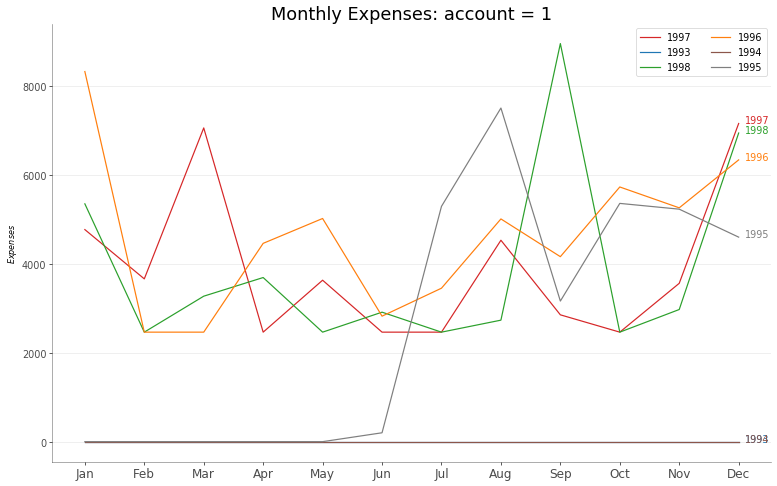

In [30]:
#transform data to pandas
df = df_complet_year.filter(col('account_id') == id_values).sort('month').toPandas()
# plot
title = "Monthly Expenses: account = " + id_values
ytitle = '$Expenses$'
date_name = 'monthly_partition'
yaxis_field = 'montly_expense'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

/Users/erikapat/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/erikapat/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


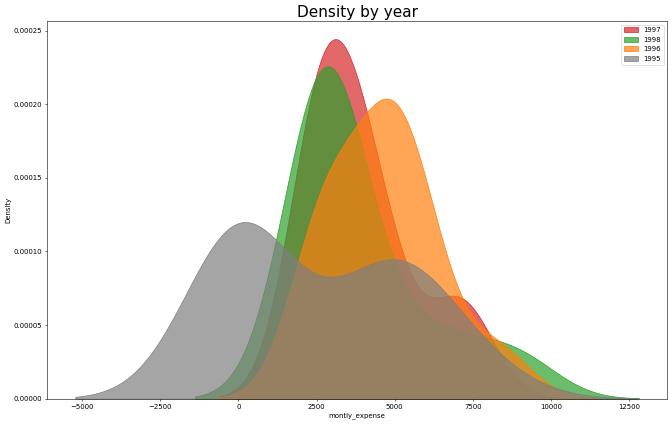

In [31]:
plot_density(df, "montly_expense", 'monthly_partition', 'Density by year')

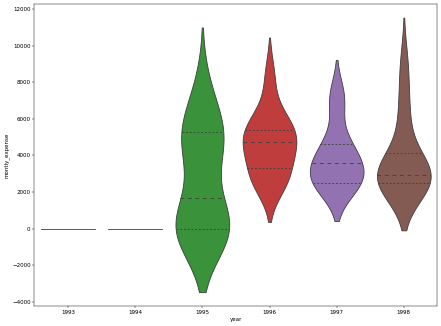

In [32]:
classes = 'year'
val =  'montly_expense'
title = ''
    
plot_violin(df, classes, val, title)

## **Outliers**

Regarding to who you are an outlier,  regarding to yourself, regarding to others in the same year. Explore the different alternatives.

In [33]:
df_group.count()

185057

In [34]:
#Outliers by account
#[change]: solve select
d_outliers = find_outliers(df_complet_year, comparison_column = ['account_id'], filed_value = 'montly_expense').sort('year')
print('number of outliers: ', d_outliers.count())
d_outliers.show(20, False)

number of outliers:  5355
+----------+----+--------------+-----------------+------------------+------------------+------------------+-------------------+---------+
|account_id|year|montly_expense|monthly_partition|mean              |stddev            |UpperLimit        |LowerLimit         |isOutlier|
+----------+----+--------------+-----------------+------------------+------------------+------------------+-------------------+---------+
|2932      |1993|171171.6      |1993-10-31       |35738.25000000002 |40767.79296010551 |158041.62888031654|-86565.12888031651 |true     |
|346       |1993|52129.6       |1993-06-30       |20901.508333333346|10330.76747469749 |51893.81075742582 |-10090.794090759126|true     |
|2357      |1993|24523.6       |1993-06-30       |6011.683333333329 |4602.632427270657 |19819.5806151453  |-7796.213948478642 |true     |
|5622      |1993|155714.6      |1993-11-30       |32623.58055555557 |28612.77019578496 |118461.89114291045|-53214.73003179931 |true     |
|9403   

## **Smoothing**

In [35]:
## Limits
d_limits = (df_complet_year.select('account_id', 'montly_expense', 'monthly_partition')
            .join( limits(df_group, comparison_column = ['account_id'], filed_value = 'montly_expense'), 'account_id', 'left').sort('account_id'))


In [36]:
from pyspark.sql.window import Window
from pyspark.sql.functions import *
import numpy as np 
from pyspark.sql.types import FloatType


def rolling_metric(df, partitioned_by = "account_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3):
    """
    Rolling Median & Mean 
    """
    
    median_udf = udf(lambda x: float(np.median(x)), FloatType())

    w = Window.partitionBy(partitioned_by).orderBy(date_field)
    df = df.withColumn("date", col(date_field).cast("date"))
    df = df.withColumn('rank', F.dense_rank().over(w))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-window_size, 1)) #windows months before, in the present month
    df = df.select("*", (F.mean(value).over(w2)).alias("rolling_avg_" + str(window_size) + "m"))
    w2 = (Window().partitionBy(partitioned_by).orderBy("rank").rangeBetween(-(window_size - 1), 0))
    df = df.withColumn("list", collect_list("montly_expense").over(w2)) \
      .withColumn("rolling_median_" + str(window_size) + "m", median_udf("list").cast('double')).drop('date', 'rank') #'list', 
    
    return df

df_rolling = (rolling_metric(d_limits, partitioned_by = "account_id", value = "montly_expense", date_field = "monthly_partition", window_size = 3))
(df_rolling.drop('mean', 'stddev', 'UpperLimit', 'LowerLimit').filter(col('account_id') == id_values).sort('monthly_partition').show(20, False))

+----------+--------------+-----------------+--------------+---------------+-----------------+
|account_id|montly_expense|monthly_partition|rolling_avg_3m|list           |rolling_median_3m|
+----------+--------------+-----------------+--------------+---------------+-----------------+
|1         |0.0           |1993-01-31       |0.0           |[0.0]          |0.0              |
|1         |0.0           |1993-02-28       |0.0           |[0.0, 0.0]     |0.0              |
|1         |0.0           |1993-03-31       |0.0           |[0.0, 0.0, 0.0]|0.0              |
|1         |0.0           |1993-04-30       |0.0           |[0.0, 0.0, 0.0]|0.0              |
|1         |0.0           |1993-05-31       |0.0           |[0.0, 0.0, 0.0]|0.0              |
|1         |0.0           |1993-06-30       |0.0           |[0.0, 0.0, 0.0]|0.0              |
|1         |0.0           |1993-07-31       |0.0           |[0.0, 0.0, 0.0]|0.0              |
|1         |0.0           |1993-08-31       |0.0  

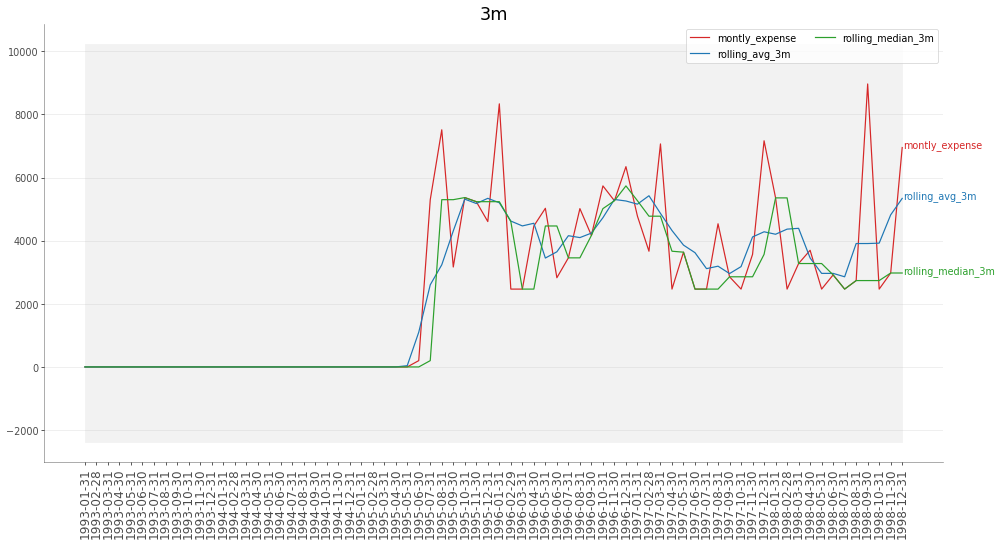

In [37]:
#3m
df = to_explode(df_rolling.select('monthly_partition', 'account_id', 'montly_expense', 'rolling_avg_3m', 'rolling_median_3m'), ['monthly_partition', 'account_id'])
df = df.filter(col('account_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('account_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='3m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

In [38]:
#2m
df_rolling = (rolling_metric(d_limits, partitioned_by = "account_id", value = "montly_expense", date_field = "monthly_partition", window_size = 2))
(df_rolling.drop('mean', 'stddev', 'UpperLimit', 'LowerLimit').filter(col('account_id') == id_values).sort('monthly_partition').show(20, False))

+----------+--------------+-----------------+--------------+----------+-----------------+
|account_id|montly_expense|monthly_partition|rolling_avg_2m|list      |rolling_median_2m|
+----------+--------------+-----------------+--------------+----------+-----------------+
|1         |0.0           |1993-01-31       |0.0           |[0.0]     |0.0              |
|1         |0.0           |1993-02-28       |0.0           |[0.0, 0.0]|0.0              |
|1         |0.0           |1993-03-31       |0.0           |[0.0, 0.0]|0.0              |
|1         |0.0           |1993-04-30       |0.0           |[0.0, 0.0]|0.0              |
|1         |0.0           |1993-05-31       |0.0           |[0.0, 0.0]|0.0              |
|1         |0.0           |1993-06-30       |0.0           |[0.0, 0.0]|0.0              |
|1         |0.0           |1993-07-31       |0.0           |[0.0, 0.0]|0.0              |
|1         |0.0           |1993-08-31       |0.0           |[0.0, 0.0]|0.0              |
|1        

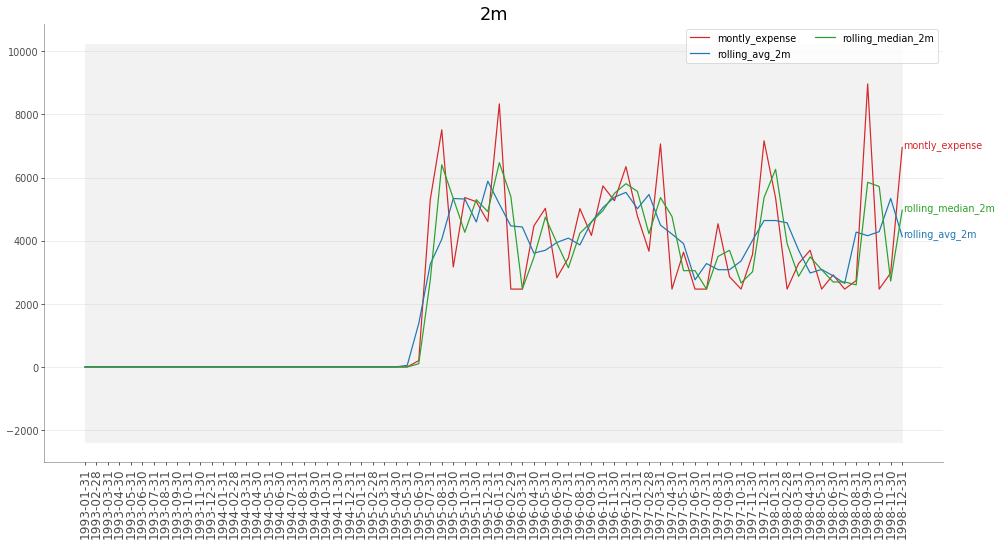

In [39]:
df = to_explode(df_rolling.select('monthly_partition', 'account_id', 'montly_expense', 'rolling_avg_2m', 'rolling_median_2m'), ['monthly_partition', 'account_id'])
df = df.filter(col('account_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('account_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='2m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

## **Income**

- If we have a expense that is due to an increase in income ¿is it a pick?
- We can have the case of persons that does not have severla incomes, these are not equal. 

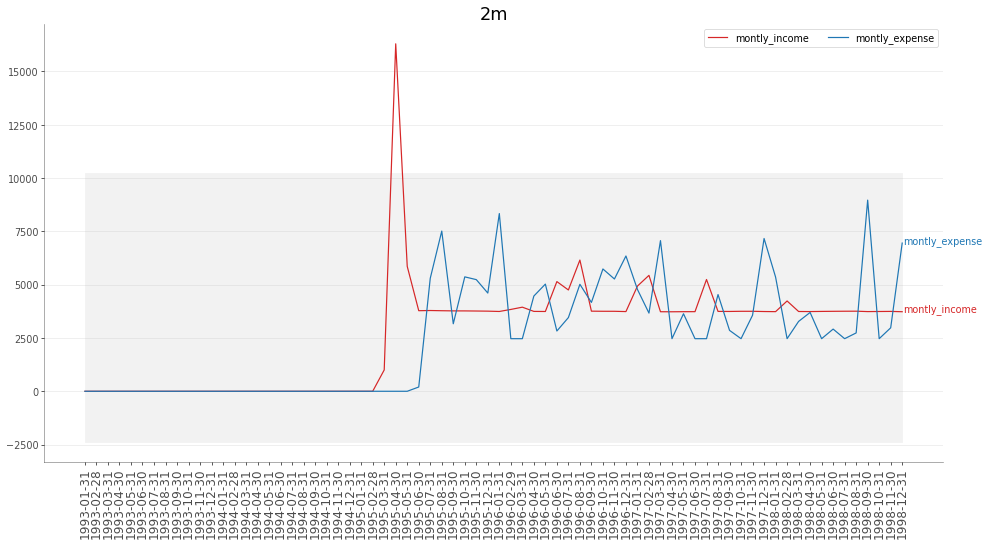

In [40]:
df = to_explode(df_complet_year.select('monthly_partition', 'account_id', 'montly_expense', 'montly_income'), ['monthly_partition', 'account_id'])
df = df.filter(col('account_id') == id_values).toPandas()
df_roll = df_rolling.filter(col('account_id') == id_values).toPandas()
plot_different_type_series_wit_limits(df, df_roll, 'monthly_partition', 'movs','field', 'UpperLimit', 'LowerLimit', title ='2m', ytitle = '',  dpi_value = 58, width = 20, height = 10)

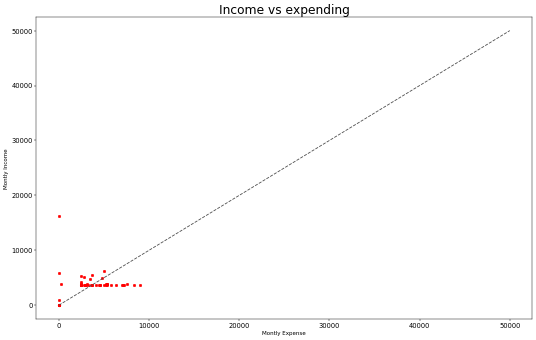

In [41]:
import math 
df_complet_year_proy = (df_complet_year.select('account_id', 'montly_income', 'montly_expense')
 .withColumn('proyection', col('montly_expense')*math.cos(45)))

title = "Income vs expending"
x_label = 'Montly Expense' 
y_label = 'Montly Income'
x_field = 'montly_expense'
y_field = 'montly_income' 


df = df_complet_year.filter(col('account_id') == id_values).toPandas()
scatter_plot(df, x_field, y_field, title, x_label, y_label, dpi =40 )

In [42]:
## Scatter

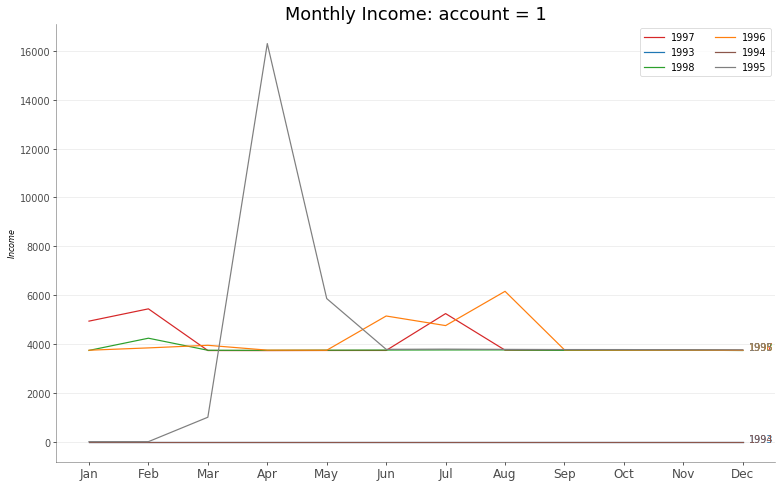

In [43]:
#transform data to pandas
df = df_complet_year.filter(col('account_id') == id_values).sort('month').toPandas()
# plot
title = "Monthly Income: account = " + id_values
ytitle = '$Income$'
date_name = 'monthly_partition'
yaxis_field = 'montly_income'
plot_different_series(df, date_name, yaxis_field, title, ytitle)

## **Change detection**

https://github.com/BMClab/BMC/blob/master/notebooks/DetectCUSUM.ipynb

In [44]:
df_group.show(2, False)

+----------+-----------------+-------------+--------------+-----------+-------------+----+-----+
|account_id|monthly_partition|montly_income|montly_expense|n_mov_trans|n_mov_expense|year|month|
+----------+-----------------+-------------+--------------+-----------+-------------+----+-----+
|8         |1998-05-31       |20657.5      |17138.6       |6          |4            |1998|5    |
|14        |1997-08-31       |14933.3      |15143.6       |5          |3            |1997|8    |
+----------+-----------------+-------------+--------------+-----------+-------------+----+-----+
only showing top 2 rows



In [45]:
#just for now but we need to complete the data

df_group_2 = df_group.sort('account_id', 'monthly_partition').filter(col('account_id') == id_values)

In [46]:
from pyspark.sql.functions import lag
from pyspark.sql.window import Window
df_group_2 = df_group_2.withColumn('sum_amount_lag', lag('sum_amount').over(
            Window.partitionBy('account_id').orderBy('monthly_partition')))

AnalysisException: "cannot resolve '`sum_amount`' given input columns: [account_id, montly_income, n_mov_trans, year, monthly_partition, month, montly_expense, n_mov_expense];;\n'Project [account_id#1016, monthly_partition#1185, montly_income#1140, montly_expense#1147, n_mov_trans#1161L, n_mov_expense#1154L, year#1168, month#1176, lag('sum_amount, 1, null) windowspecdefinition(account_id#1016, monthly_partition#1185 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS sum_amount_lag#2009]\n+- Filter (account_id#1016 = cast(1 as int))\n   +- Sort [account_id#1016 ASC NULLS FIRST, monthly_partition#1185 ASC NULLS FIRST], true\n      +- Project [account_id#1016, cast(monthly_partition#1090 as string) AS monthly_partition#1185, montly_income#1140, montly_expense#1147, n_mov_trans#1161L, n_mov_expense#1154L, year#1168, month#1176]\n         +- Project [account_id#1016, monthly_partition#1090, montly_income#1140, montly_expense#1147, n_mov_trans#1161L, n_mov_expense#1154L, year#1168, month(cast(monthly_partition#1090 as date)) AS month#1176]\n            +- Project [account_id#1016, monthly_partition#1090, montly_income#1140, montly_expense#1147, n_mov_trans#1161L, n_mov_expense#1154L, year(cast(monthly_partition#1090 as date)) AS year#1168]\n               +- Project [account_id#1016, monthly_partition#1090, montly_income#1140, montly_expense#1147, count(monthly_partition)#1132L AS n_mov_trans#1161L, n_mov_expense#1154L]\n                  +- Project [account_id#1016, monthly_partition#1090, montly_income#1140, montly_expense#1147, count(monthly_partition)#1132L, sum(is_expense)#1133L AS n_mov_expense#1154L]\n                     +- Project [account_id#1016, monthly_partition#1090, montly_income#1140, sum(expense)#1131 AS montly_expense#1147, count(monthly_partition)#1132L, sum(is_expense)#1133L]\n                        +- Project [account_id#1016, monthly_partition#1090, sum(income)#1130 AS montly_income#1140, sum(expense)#1131, count(monthly_partition)#1132L, sum(is_expense)#1133L]\n                           +- Aggregate [account_id#1016, monthly_partition#1090], [account_id#1016, monthly_partition#1090, sum(income#1098) AS sum(income)#1130, sum(expense#1107) AS sum(expense)#1131, count(monthly_partition) AS count(monthly_partition)#1132L, sum(cast(is_expense#1071 as bigint)) AS sum(is_expense)#1133L]\n                              +- Project [trans_id#1015, date#1059, account_id#1016, balance#1021, amount#1020, is_expense#1071, monthly_partition#1090, income#1098, CASE WHEN (is_expense#1071 = 1) THEN amount#1020 ELSE cast(0 as double) END AS expense#1107]\n                                 +- Project [trans_id#1015, date#1059, account_id#1016, balance#1021, amount#1020, is_expense#1071, monthly_partition#1090, CASE WHEN (is_expense#1071 = 0) THEN amount#1020 ELSE cast(0 as double) END AS income#1098]\n                                    +- Sort [account_id#1016 ASC NULLS FIRST, date#1059 ASC NULLS FIRST, trans_id#1015 ASC NULLS FIRST], true\n                                       +- Project [trans_id#1015, date#1059, account_id#1016, balance#1021, amount#1020, is_expense#1071, date_format(cast(date_sub(add_months(trunc(date#1059, month), 1), 1) as timestamp), yyyy-MM-dd, Some(Europe/Madrid)) AS monthly_partition#1090]\n                                          +- Project [trans_id#1015, date#1059, account_id#1016, balance#1021, amount#1020, is_expense#1071]\n                                             +- Project [trans_id#1015, account_id#1016, date#1059, type#1018, operation#1019, amount#1020, balance#1021, k_symbol#1022, bank#1023, account#1024, orig_date#1035, CASE WHEN (type#1018 = VYDAJ) THEN 1 ELSE 0 END AS is_expense#1071]\n                                                +- Project [trans_id#1015, account_id#1016, to_date(from_unixtime(unix_timestamp('date, yyMMdd, None), yyyy-MM-dd HH:mm:ss, None), None) AS date#1059, type#1018, operation#1019, amount#1020, balance#1021, k_symbol#1022, bank#1023, account#1024, orig_date#1035]\n                                                   +- Project [trans_id#1015, account_id#1016, to_date(from_unixtime(unix_timestamp('orig_date, yyMMdd, None), yyyy-MM-dd HH:mm:ss, None), None) AS date#1047, type#1018, operation#1019, amount#1020, balance#1021, k_symbol#1022, bank#1023, account#1024, orig_date#1035]\n                                                      +- Project [trans_id#1015, account_id#1016, date#1017, type#1018, operation#1019, amount#1020, balance#1021, k_symbol#1022, bank#1023, account#1024, cast(date#1017 as string) AS orig_date#1035]\n                                                         +- Relation[trans_id#1015,account_id#1016,date#1017,type#1018,operation#1019,amount#1020,balance#1021,k_symbol#1022,bank#1023,account#1024] csv\n"

In [ ]:
df_group_2.sort('account_id', 'monthly_partition').show(5, False)

In [ ]:
df_group_2 = df_group_2.withColumn('s_pos', col('sum_amount_lag') - col('sum_amount')).withColumn('cumsum', sf.sum('s_pos').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('s_neg', - col('sum_amount_lag') + col('sum_amount')).withColumn('cumsum', sf.sum('s_neg').over(Window.partitionBy('account_id').orderBy('monthly_partition')))
df_group_2 = df_group_2.withColumn('g_neg', sf.when(col('s_neg')> 0, col('s_neg')).otherwise(0))
df_group_2 = df_group_2.withColumn('g_pos', sf.when(col('s_pos')> 0, col('s_pos')).otherwise(0))
df_group_2.show(20, False)                                                                                  

In [ ]:
df_g = df_group_2.toPandas()
plt.plot(df_g['monthly_partition'], df_g['g_neg'], c = 'b', label = 'g_neg')
plt.plot(df_g['monthly_partition'], df_g['g_pos'], c = 'r', label = 'g_pos')
#plt.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
#plt.plot(mean_plus_std, 'k--', label = 'Prediction Bounds')
#plt.plot(mean_minus_std, 'k--')
#plt.scatter(outliers.index, outliers['Users'], c = 'r', marker = 'o', s = 120, label = 'Outliers')
plt.legend()